In [67]:
import pandas as pd
import numpy as np
from sklearn import linear_model
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.ensemble import RandomForestRegressor
from datetime import datetime
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import PoissonRegressor
from sklearn.pipeline import Pipeline

In [68]:
accident_data=pd.read_csv('./accident.csv')
casualty_data = pd.read_csv('./Cas.csv')
accident_data.head()

C:\Users\mbashir\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (31) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


,Accident_Index,Location_Easting_OSGR,Location_Northing_OSGR,Longitude,Latitude,Police_Force,Accident_Severity,Number_of_Vehicles,Number_of_Casualties,Date,...,Pedestrian_Crossing-Human_Control,Pedestrian_Crossing-Physical_Facilities,Light_Conditions,Weather_Conditions,Road_Surface_Conditions,Special_Conditions_at_Site,Carriageway_Hazards,Urban_or_Rural_Area,Did_Police_Officer_Attend_Scene_of_Accident,LSOA_of_Accident_Location
0,2016010000005,519310.0,188730.0,-0.279323,51.584754,1,3,2,1,01/11/2016,...,0,0,5,1,1,0,0,1,1,E01000543
1,2016010000006,551920.0,174560.0,0.184928,51.449595,1,3,1,1,01/11/2016,...,0,0,4,1,1,0,0,1,1,E01000375
2,2016010000008,505930.0,183850.0,-0.473837,51.543563,1,3,1,1,01/11/2016,...,0,0,4,1,1,0,0,1,1,E01033725
3,2016010000016,527770.0,168930.0,-0.164442,51.404958,1,3,1,1,01/11/2016,...,0,0,1,1,1,0,0,1,1,E01003379
4,2016010000018,510740.0,177230.0,-0.406580,51.483139,1,3,2,1,01/11/2016,...,0,0,1,1,1,0,0,1,1,E01002583


In [69]:
def month_from_date(date):
    dmyyyy = datetime.strptime(date, '%d/%m/%Y')
    return int(datetime.strftime(dmyyyy, '%m'))
accident_data['Month_of_Year']=accident_data['Date'].apply(month_from_date)

def hour_from_time(time):
    try:
        hhmm = datetime.strptime(time, '%H:%M')
        return int(datetime.strftime(hhmm, '%H'))
    except Exception:
        return 0
accident_data['Hour_of_Day']=accident_data['Time'].apply(hour_from_time)

accident_data= accident_data[['Accident_Index', 'Longitude','Latitude', 'Day_of_Week','Light_Conditions','Weather_Conditions',
     'Road_Surface_Conditions','Urban_or_Rural_Area','Month_of_Year', 'Hour_of_Day']]

In [70]:
print(accident_data.shape)
accident_data.head()

(136621, 10)


,Accident_Index,Longitude,Latitude,Day_of_Week,Light_Conditions,Weather_Conditions,Road_Surface_Conditions,Urban_or_Rural_Area,Month_of_Year,Hour_of_Day
0,2016010000005,-0.279323,51.584754,3,5,1,1,1,11,2
1,2016010000006,0.184928,51.449595,3,4,1,1,1,11,0
2,2016010000008,-0.473837,51.543563,3,4,1,1,1,11,1
3,2016010000016,-0.164442,51.404958,3,1,1,1,1,11,9
4,2016010000018,-0.406580,51.483139,3,1,1,1,1,11,7


In [71]:
###drop rows with location data naa
accident_data.dropna(subset = ["Longitude"], inplace=True)
accident_data.dropna(subset = ["Latitude"], inplace=True)
print(accident_data.shape)

(136614, 10)


In [72]:
#####causality data processing
###keep only cycling causality data
casualty_data = casualty_data[casualty_data.Casualty_Type==1]
casualty_data= casualty_data[['Accident_Index', 'Sex_of_Casualty','Age_Band_of_Casualty', 'Casualty_Type',
                              'Casualty_Home_Area_Type']]
casualty_data.head()

,Accident_Index,Sex_of_Casualty,Age_Band_of_Casualty,Casualty_Type,Casualty_Home_Area_Type
4,2016010000018,1,6,1,1
17,2016010000046,1,4,1,1
29,2016010000058,1,5,1,1
35,2016010000069,1,6,1,1
36,2016010000072,1,5,1,1


In [73]:
#merge accident and casuality data based on Accident Index
casualty_and_accident_data = pd.merge(accident_data, casualty_data, on='Accident_Index', how='left')
casualty_and_accident_data = casualty_and_accident_data.drop(['Accident_Index'], axis=1)

In [74]:
print(casualty_and_accident_data.shape)
casualty_and_accident_data.head()

(136827, 13)


,Longitude,Latitude,Day_of_Week,Light_Conditions,Weather_Conditions,Road_Surface_Conditions,Urban_or_Rural_Area,Month_of_Year,Hour_of_Day,Sex_of_Casualty,Age_Band_of_Casualty,Casualty_Type,Casualty_Home_Area_Type
0,-0.279323,51.584754,3,5,1,1,1,11,2,NaN,NaN,NaN,NaN
1,0.184928,51.449595,3,4,1,1,1,11,0,NaN,NaN,NaN,NaN
2,-0.473837,51.543563,3,4,1,1,1,11,1,NaN,NaN,NaN,NaN
3,-0.164442,51.404958,3,1,1,1,1,11,9,NaN,NaN,NaN,NaN
4,-0.406580,51.483139,3,1,1,1,1,11,7,1.0,6.0,1.0,1.0


In [75]:
casualty_and_accident_data.fillna(0, inplace=True)

# Casualty data after merge is cast to float. Cast back to integer
casualty_and_accident_data['Casualty_Type'] = casualty_and_accident_data['Casualty_Type'].astype(int)

# We will use Casualty_Type as an indicator of a cycling accident. If 1 it is a cycling accident and if 0 a non-cycling accident
casualty_and_accident_data = casualty_and_accident_data.rename(columns={'Casualty_Type': 'Cycling_Accident'})
# Convert the latitude and longitude coordinates to area squares
latitude_min = min(casualty_and_accident_data['Latitude'])
latitude_max = max(casualty_and_accident_data['Latitude'])
longitude_min = min(casualty_and_accident_data['Longitude'])
longitude_max = max(casualty_and_accident_data['Longitude'])

# Determine the required step for a given number of areas
latitude_step = (latitude_max - latitude_min) / 1000
longitude_step = (longitude_max - longitude_min) / 1000

# Determine the latitude area
def calc_lat_area(current_lat):
    return int((current_lat - latitude_min) / latitude_step)

# Determine the longitude area
def calc_lon_area(current_lon):
    return int((current_lon - longitude_min) / longitude_step)

# Create new columns with the latitude and longitude areas
casualty_and_accident_data["Latitude_Area"] = list(map(calc_lat_area, casualty_and_accident_data["Latitude"]))
casualty_and_accident_data["Longitude_Area"] = list(map(calc_lon_area, casualty_and_accident_data["Longitude"]))

# Drop the old latitude and logitude columns
casualty_and_accident_data = casualty_and_accident_data.drop(['Longitude', 'Latitude'], axis=1)

# Display our data
casualty_and_accident_data.head()

,Day_of_Week,Light_Conditions,Weather_Conditions,Road_Surface_Conditions,Urban_or_Rural_Area,Month_of_Year,Hour_of_Day,Sex_of_Casualty,Age_Band_of_Casualty,Cycling_Accident,Casualty_Home_Area_Type,Latitude_Area,Longitude_Area
0,3,5,1,1,1,11,2,0.0,0.0,0,0.0,157,777
1,3,4,1,1,1,11,0,0.0,0.0,0,0.0,144,828
2,3,4,1,1,1,11,1,0.0,0.0,0,0.0,153,756
3,3,1,1,1,1,11,9,0.0,0.0,0,0.0,140,789
4,3,1,1,1,1,11,7,1.0,6.0,1,1.0,147,763


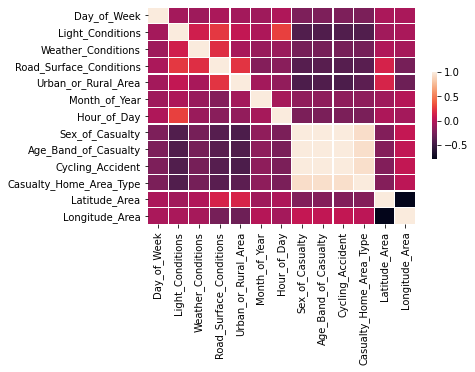

In [76]:
#heatmap to see correlation
corr=casualty_and_accident_data.corr()
sns.heatmap(corr.corr(), linewidth=0.3, cbar_kws={"shrink": .4})
plt.show()

In [77]:
x_data = casualty_and_accident_data.drop(['Cycling_Accident'], axis=1)
y_data = casualty_and_accident_data['Cycling_Accident']
# training and test data splits and training regression model
X_train, X_test, y_train, y_test = train_test_split(x_data.values, 
                                                    y_data.values,
                                                    test_size=0.2,
                                                    random_state=42)

In [92]:
pipe = make_pipeline(StandardScaler(), PoissonRegressor())
pipe.fit(X_train, y_train)  # apply scaling on training data
Pipeline(steps=[('standardscaler', StandardScaler()),
                ('regressor', PoissonRegressor())])

pipe.score(X_test, y_test)

poisson_glm = Pipeline(steps=[('standardscaler', StandardScaler()),
                ('regressor', PoissonRegressor())])
poisson_glm.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('regressor', PoissonRegressor())])

In [93]:
y_pred = poisson_glm.predict(X_test)
print("Poisson Regression score: %.2f" % poisson_glm.score(X_train, y_train))
print("Mean absolute error: %.2f" % np.mean(np.absolute(y_pred - y_test)))
print("Residual sum of squares (MSE): %.2f" % np.mean((y_pred - y_test) ** 2))
print("R2-score: %.2f" % r2_score(y_pred , y_test))

Poisson Regression score: 0.52
Mean absolute error: 0.16
Residual sum of squares (MSE): 0.06
R2-score: -2.52


In [94]:
pipe.score(X_test, y_test)

0.5198371731919784